#FSL MODEL ANALYSIS
### AUTHOR: ISAIAH TUPAL
#### Description
This is to visualize the model training result as well as to test the model using the test dataset. These models are per category

In [1]:
from tqdm.auto import tqdm
from keras.utils.np_utils import to_categorical
from pathlib import Path
from sklearn import metrics




import matplotlib.pyplot as plt
import tensorflow as tf

import pandas as pd
import numpy as np
import mediapipe as mp
import imageio
import cv2
import os
import pickle 

import GCN as gcn
import STSGraph as STS
import tools as tl

import importlib
import seaborn as sn

importlib.reload(gcn)
importlib.reload(plt)

<module 'matplotlib.pyplot' from 'c:\\Users\\isaia\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [2]:
#paths
#path to project

path_to_training= Path(os.getcwd() )
path_to_project = Path(os.path.abspath(os.path.join(path_to_training, os.pardir)))
path_to_trained_models = path_to_training / "trained_models"
path_to_processed = path_to_training / "processed" 



In [3]:
"""
Get the category
"""

path_to_labels = path_to_project / "labels.csv"
path_to_test = path_to_project / "test.csv"
path_to_train = path_to_project / "train.csv"

test = pd.read_csv(path_to_test)
label = pd.read_csv(path_to_labels)
train = pd.read_csv(path_to_train)

#find how many videos are there per category
cat_list = label['category'].unique()
cat_num_analysis= {}
train_num = []
test_num = []
total_num = []

for cat in cat_list:
    cat_vid_report = "{} has {} training videos and {} test videos which totals to {} videos"
    train_num.append(len(train.loc[train['category'] == cat].index))
    test_num.append(len(test.loc[train['category'] == cat].index))
    total_num.append( len(train.loc[train['category'] == cat].index) + len(test.loc[train['category'] == cat].index) ) #yes i know this code terrible but ughh too lazy to fix plus its save memory,, i think

cat_num_analysis["Category"] = cat_list
cat_num_analysis["Number of videos in train"] = train_num
cat_num_analysis["Number of videos in test"] = test_num
cat_num_analysis["Number of videos in total"] = total_num
cat_num_df = pd.DataFrame(cat_num_analysis)
print(cat_num_df.to_string())



        Category  Number of videos in train  Number of videos in test  Number of videos in total
0       GREETING                        164                        40                        204
1       SURVIVAL                        167                        48                        215
2         NUMBER                        162                        37                        199
3       CALENDAR                        196                        42                        238
4           DAYS                        161                        37                        198
5         FAMILY                        160                        47                        207
6  RELATIONSHIPS                        162                        44                        206
7          COLOR                        209                        52                        261
8           FOOD                        160                        32                        192
9          DRINK              

# Summary of the model

In [4]:
default_output_size = 10
model_template = gcn.gcn(output_size = default_output_size)
model_template.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_feature_inp_layer (InputL  [(None, 2010, 4)]   0           []                               
 ayer)                                                                                            
                                                                                                  
 graph_adj_layer (InputLayer)   [(None, 2010, 2010)  0           []                               
                                ]                                                                 
                                                                                                  
 gcn_conv (GCNConv)             (None, None, 256)    1280        ['node_feature_inp_layer[0][0]', 
                                                                  'graph_adj_layer[0][0]']    

# TRAINING RESULTS PLOT
## This section is to plot the loss and the accuracy of the mode over time

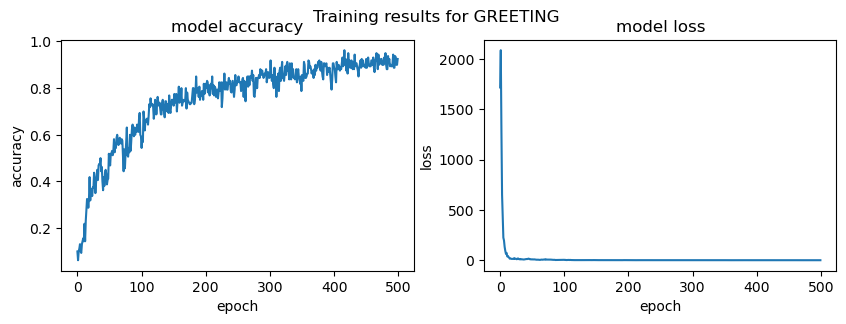

Final loss is  1.4741, Final accuracy is 0.9250


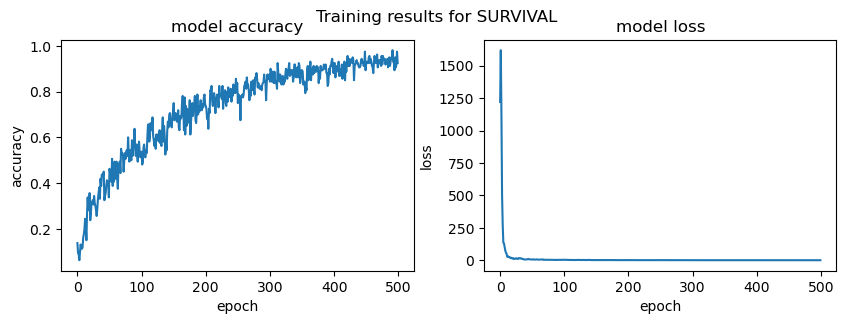

Final loss is  1.6007, Final accuracy is 0.9250


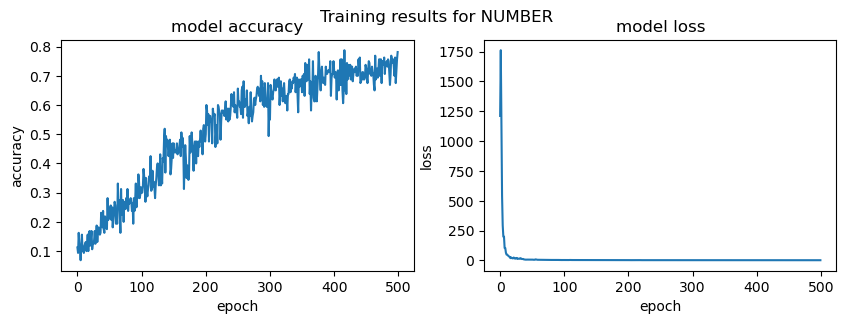

Final loss is  2.0760, Final accuracy is 0.7812


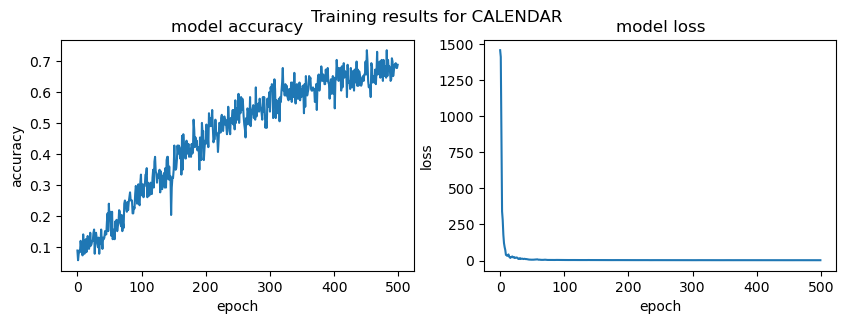

Final loss is  2.1157, Final accuracy is 0.6875


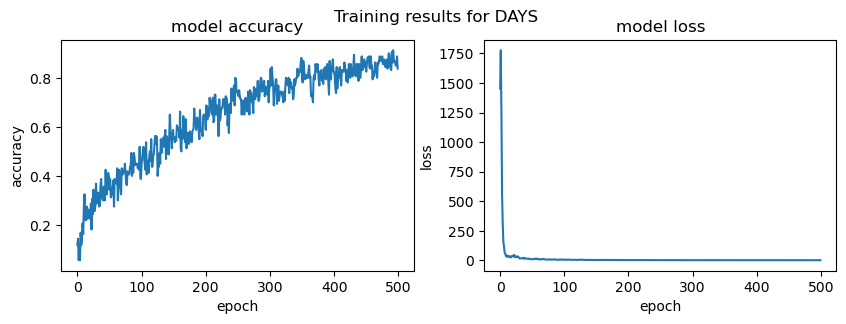

Final loss is  1.8051, Final accuracy is 0.8375


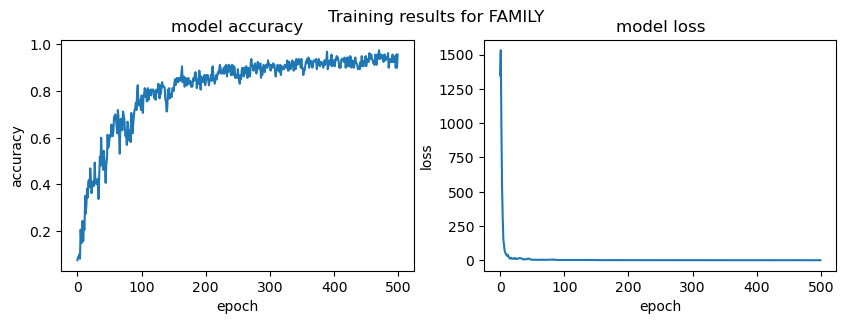

Final loss is  1.4917, Final accuracy is 0.9563


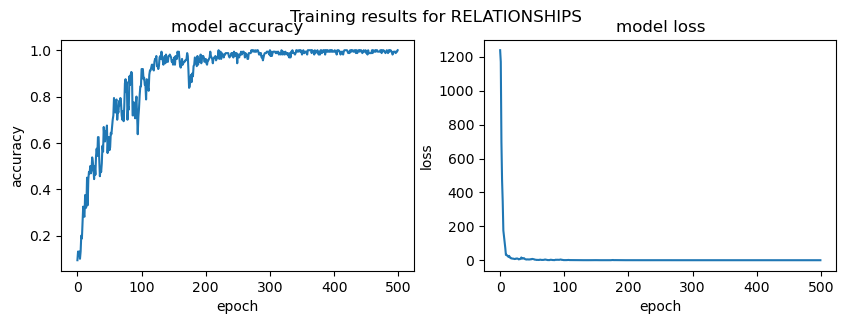

Final loss is  1.2630, Final accuracy is 1.0000


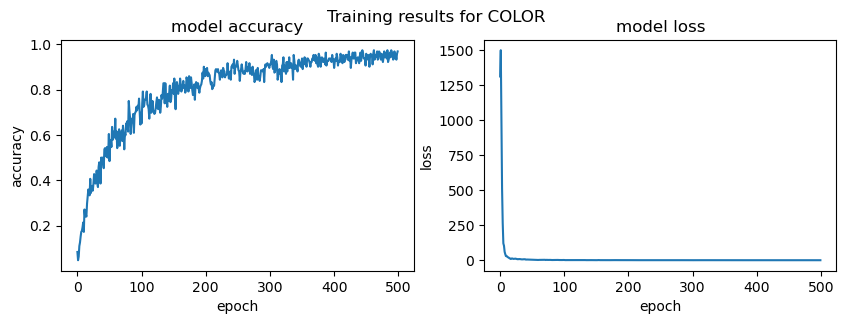

Final loss is  1.4946, Final accuracy is 0.9688


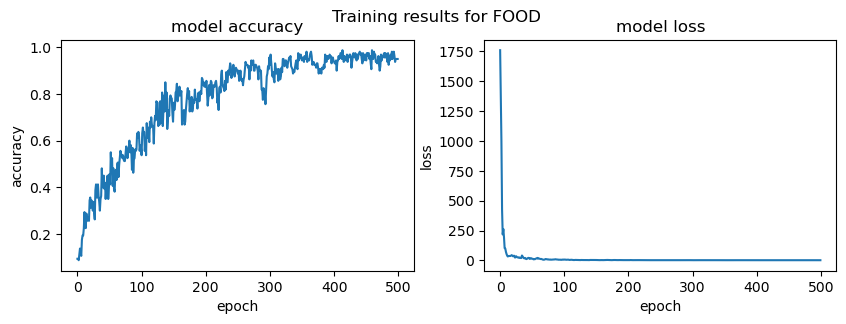

Final loss is  1.3163, Final accuracy is 0.9500


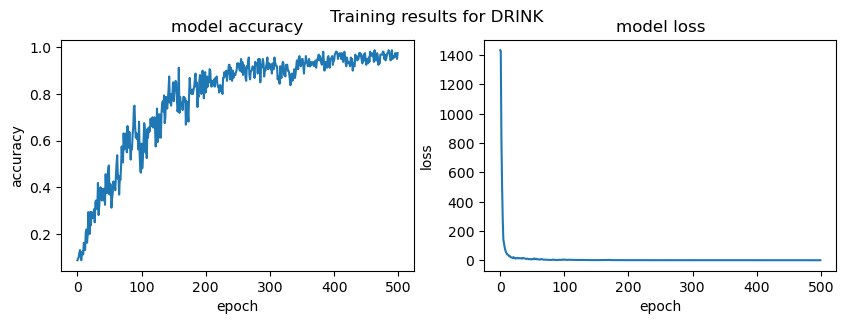

Final loss is  1.2544, Final accuracy is 0.9750


In [5]:

#for reference
#path_to_trained_models = path_to_training / "trained_models"
#path_to_processed = path_to_training / "training"

def plot_training_and_loss(category):
    hist_file_name = category + "history"
    #get history file
    path_to_cat_history = path_to_trained_models / hist_file_name
    with open(path_to_cat_history, 'rb') as handle:
        history = pickle.load(handle)


    #summarize training data
    fig, ax = plt.subplots(1, 2, figsize=(10,3))




    ax[0].plot(history['acc'])

    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')


    # summarize history for loss

    ax[1].plot(history['loss'])

    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    
    
    plt.suptitle("Training results for " + category)
   
    plt.show()
    report = "Final loss is  {0:.4f}, Final accuracy is {1:.4f}"
    print(report.format( history['loss'][-1] , history['acc'][-1]))

for i in range(len(cat_list)):
    plot_training_and_loss(cat_list[i])

# Test results evaluation per category


In [6]:
def get_results(category):
    """
    Returns
    (accuracy,evalution),prediction, y_true 
    """

    #load test data
    X_nodes_test_path = path_to_processed / category / "X_nodes_test.npy"
    Y_label_test_path  = path_to_processed / category / "Y_label_test.npy"

    X_nodes_test = np.load(X_nodes_test_path,allow_pickle=True)
    Y_label_test = np.load(Y_label_test_path,allow_pickle=True)
    spektral_data = STS.STS_DATASET(X_nodes_test)


    #get model
    model_name = category+"model"
    print(model_name)
    model_path = path_to_trained_models / model_name

    #to know how many labels or outupt nodes
    label_uniq = label.loc[label['category']==category]['label'].unique() 
    model = gcn.gcn(len(label_uniq))
    model.load_weights(model_path)

    evaluation_result = model.evaluate(spektral_data.read_as_tensor(),Y_label_test,verbose=0)

    pred = model.predict(x=spektral_data.read_as_tensor(),verbose=0)
    
    #results
    #added the Y_labels test since this function is loading it 
    return evaluation_result, pred, Y_label_test 

eval_list = []
pred_list = []
y_true_list = []
for cat in cat_list:
    eval,pred,y_true = get_results(cat)
    eval_list.append(eval)
    pred_list.append(pred)
    y_true_list.append(y_true)
    report = "For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}"
    print(report)
    




GREETINGmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
SURVIVALmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
NUMBERmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
CALENDARmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
DAYSmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
FAMILYmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
RELATIONSHIPSmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
COLORmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
FOODmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}
DRINKmodel
For {0} Final loss is  {1:.4f}, Final accuracy is {2:.4f}


In [10]:
#summarize result to a dataframe
acc_list = []
lost_list = []
for i in range(len(cat_list)):
    acc_list.append(eval_list[i][1])
    lost_list.append(eval_list[i][0])

results_dict = {}
results_dict["category"] = cat_list
results_dict["test Accuracy"] = acc_list
results_dict["test loss"] = lost_list

results_df = pd.DataFrame(results_dict)
print(results_df.to_string())

        category  test Accuracy  test loss
0       GREETING       0.785714  28.546782
1       SURVIVAL       0.756098  29.574409
2         NUMBER       0.475000  29.013981
3       CALENDAR       0.333333  45.261681
4           DAYS       0.850000  29.023859
5         FAMILY       0.850000  29.069653
6  RELATIONSHIPS       0.975000  28.958935
7          COLOR       0.884615  50.540798
8           FOOD       0.975000  28.917313
9          DRINK       0.900000  28.872229


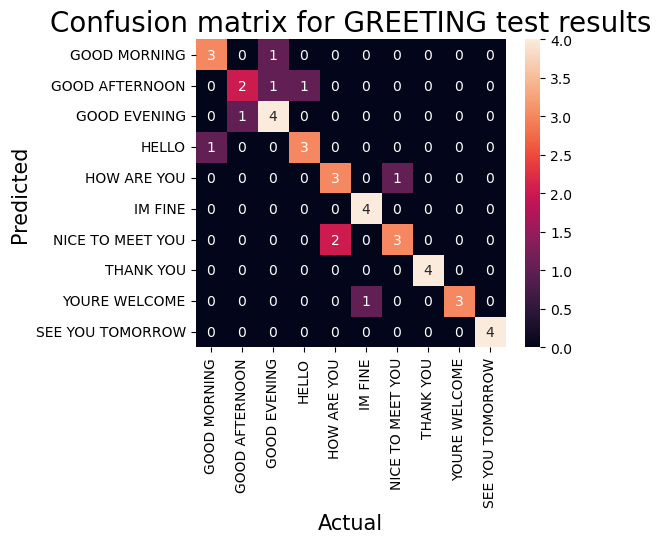

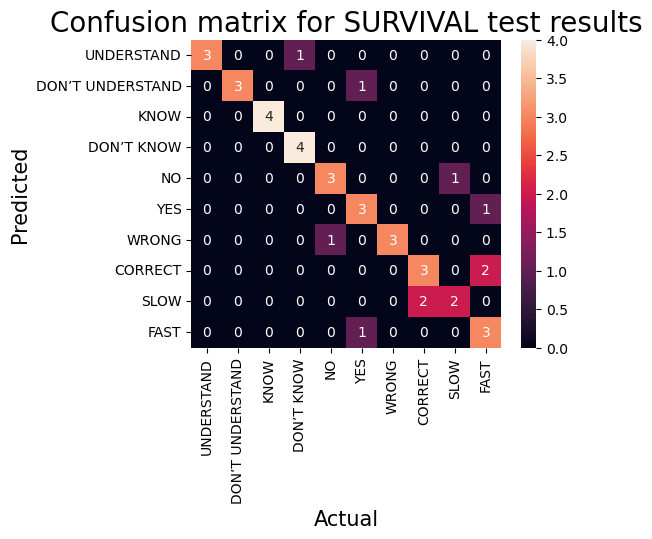

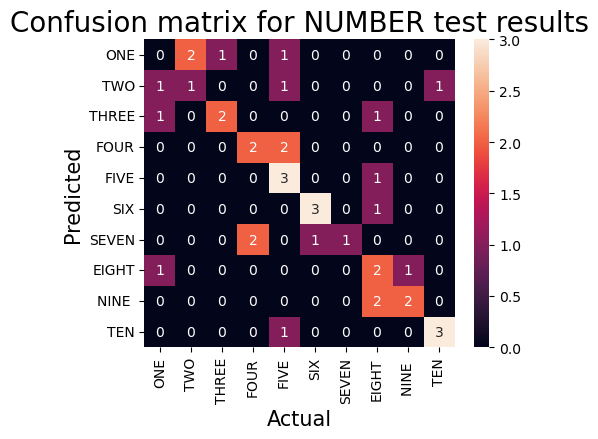

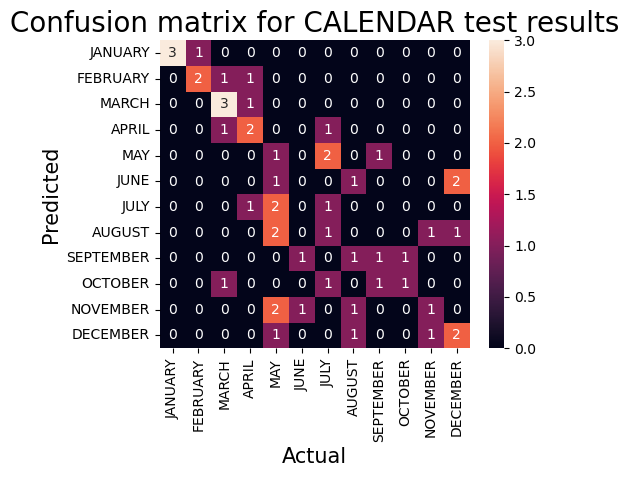

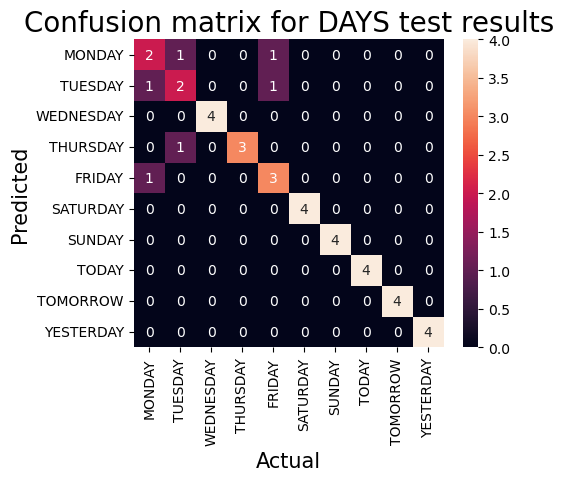

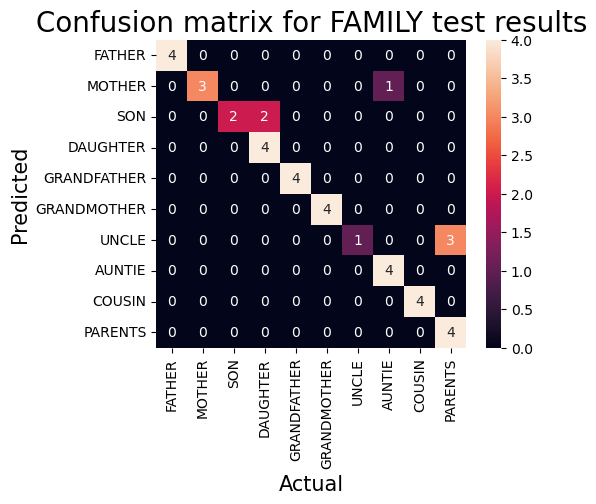

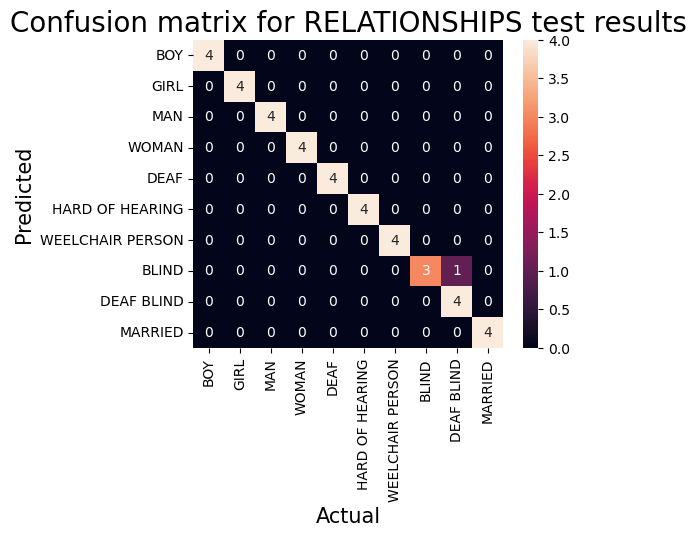

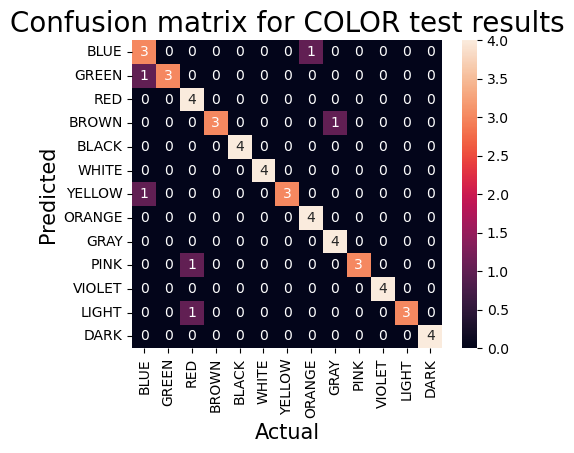

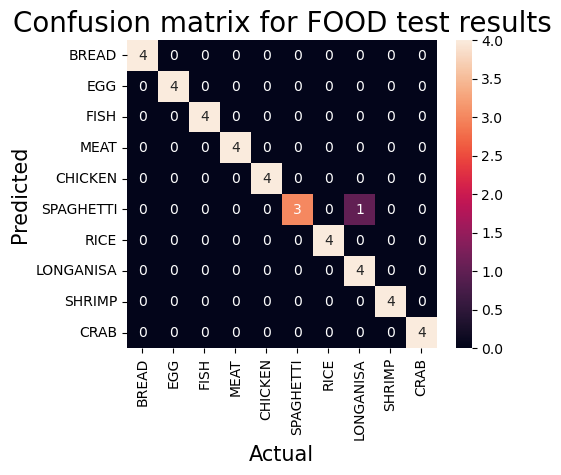

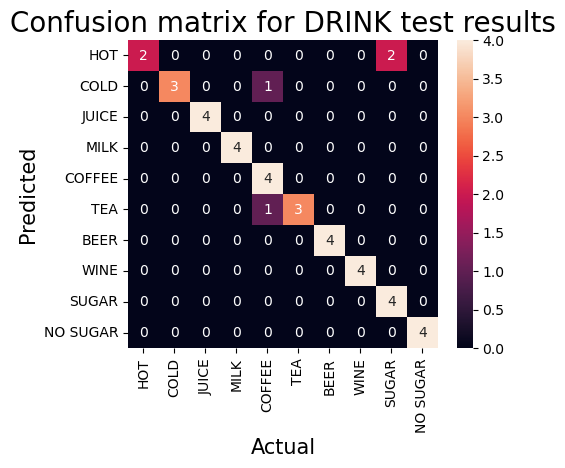

In [8]:
#confusion matrix per model



def display_cm(category,Y_true,raw_predicted):
    Y_pred = np.argmax(raw_predicted, axis=1)


    cm = metrics.confusion_matrix(Y_true, Y_pred)

    

    label_subset = label.loc[label['category']==category]
    cat_labels = label_subset['label'].values.tolist()

    df_cm = pd.DataFrame(cm, index = cat_labels,
                  columns = cat_labels)
    
    plt.figure(figsize = (5,4))
    sn.heatmap(df_cm, annot=True)
    
    plt.title("Confusion matrix for " + category + " test results",fontsize = 20)
    plt.xlabel('Actual', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('Predicted', fontsize = 15) # y-axis label with fontsize 15

    plt.show()

for i in range(len(cat_list)):
    display_cm(cat_list[i],y_true_list[i],pred_list[i])

    
